<a href="https://colab.research.google.com/github/soyJung/UHI-Morphology/blob/main/WPS/UrbanMorpho_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

geo_em.d01.nc 파일을 읽어들여 LU_INDEX를 표현하는 코드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
!pip install Cartopy netcdf4 scikit-image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.12.1-1~jammy0).
libproj-dev is already the newest version (9.3.1-1~jammy0).
proj-bin is already the newest version (9.3.1-1~jammy0).
proj-data is already the newest version (9.3.1-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from skimage.morphology import convex_hull_image
from skimage.measure import regionprops
from scipy.ndimage import binary_erosion

In [ ]:
f = '/content/drive/MyDrive/UHI/geo_em.mod.nc'
df = xr.open_dataset(f)
print(df["LU_INDEX"])

<xarray.DataArray 'LU_INDEX' (Time: 1, south_north: 149, west_east: 149)> Size: 89kB
[22201 values with dtype=float32]
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    units:        category
    description:  Dominant category
    stagger:      M
    sr_x:         1
    sr_y:         1


In [ ]:
def find_start_pixels_with_lat_logic(wrf_file_path, lu_index_value=13, split_lat=35.21):
    """
    특정 위도를 기준으로 LU_INDEX=13인 시작 픽셀들을 찾고 그룹화하여 반환합니다.
    """
    try:
        ds = xr.open_dataset(wrf_file_path)
    except FileNotFoundError:
        print(f"오류: 파일을 찾을 수 없습니다: {wrf_file_path}")
        return None

    lu_index_da = ds['LU_INDEX'].isel(Time=0)
    lat_da      = ds['CLAT'].isel(Time=0)
    landmask_da = ds['LANDMASK'].isel(Time=0)

    original_lu_index_values = lu_index_da.values.copy()
    rows, cols = original_lu_index_values.shape

    start_pixels_below = set()
    start_pixels_above = set()

    # 1. 위도 35.22보다 아래 영역에서 행(row) 기반 탐색
    for y in range(rows):
        # 현재 행의 위도 값
        current_lat = lat_da.values[y, 0]

        if current_lat < split_lat:
          # 행을 왼쪽에서 오른족으로 순회
          for x in range(cols):
              if original_lu_index_values[y, x] == lu_index_value:
                  start_pixels_below.add((y, x))
                  break # 해당 행의 첫 번째 픽셀만 찾고 다음 행으로 이동

    # 2. 위도 35.22도보다 위 영역에서 열(column) 기반 탐색
    for x in range(cols):
        # 열을 위에서 아래로 순회 (y가 큰 값에서 작은 값으로)
        for y in range(rows - 1, -1, -1):
            # 현재 픽셀의 위도 값
            current_lat = lat_da.values[y, x]

            if current_lat >= split_lat:
                if original_lu_index_values[y, x] == lu_index_value:
                    start_pixels_above.add((y, x))
                    break  # 해당 열의 첫 번째 픽셀만 찾고 다음 열로 이동

    # 3. 시작 픽셀 집합을 확장
    expanded_start_pixels_below = start_pixels_below.copy()
    expanded_start_pixels_above = start_pixels_above.copy()
    for y, x in start_pixels_below:
        if y-1 < rows and x >= 0:
            expanded_start_pixels_below.add((y-1, x))

    for y, x in start_pixels_above:
        if y+1 < rows and x >= 0:
            expanded_start_pixels_above.add((y+1, x))
        if y < rows and x + 1 >= 0:
            expanded_start_pixels_above.add((y, x + 1))
        if y + 1 < rows and x + 1 >= 0:
            expanded_start_pixels_above.add((y + 1, x + 1))

    start_pixels_below = expanded_start_pixels_below
    start_pixels_above = expanded_start_pixels_above

    if not start_pixels_below and not start_pixels_above:
        print(f"LU_INDEX 값이 {lu_index_value}인 픽셀을 찾을 수 없습니다.")
        return None, None

    print(f"위도 {split_lat}도 미만 시작 픽셀: {len(start_pixels_below)}개")
    print(f"위도 {split_lat}도 이상 시작 픽셀: {len(start_pixels_above)}개")

    mask_below = np.zeros_like(original_lu_index_values, dtype=bool)
    mask_above = np.zeros_like(original_lu_index_values, dtype=bool)

    for y, x in start_pixels_below:
        mask_below[y, x] = True
    for y, x in start_pixels_above:
        mask_above[y, x] = True

    plt.figure(figsize=(10, 8))
    # 'below' 픽셀은 파란색 계열, 'above' 픽셀은 빨간색 계열로 표시
    plt.imshow(mask_below, cmap='Blues', origin='lower', alpha=0.7)
    plt.imshow(mask_above, cmap='Reds', origin='lower', alpha=0.7)
    # LU_INDEX=13인 원본 영역을 배경으로 깔아주면 좋습니다. (선택 사항)
    # plt.imshow(original_lu_index_values == lu_index_value, cmap='Greys', origin='lower', alpha=0.0)

    plt.title(f'시작 픽셀 시각화 (기준 위도: {split_lat}°)\n'
              f'아래 픽셀: {len(start_pixels_below)}개 (파란색), 위 픽셀: {len(start_pixels_above)}개 (빨간색)')
    plt.xlabel('X (열)')
    plt.ylabel('Y (행)')
    plt.grid(False)
    plt.show()

    return start_pixels_below, start_pixels_above

위도 35.21도 미만 시작 픽셀: 29개
위도 35.21도 이상 시작 픽셀: 68개


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51089 (\N{HANGUL SYLLABLE JAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54589 (\N{HANGUL SYLLABLE PIG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49472 (\N{HANGUL SYLLABLE SEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

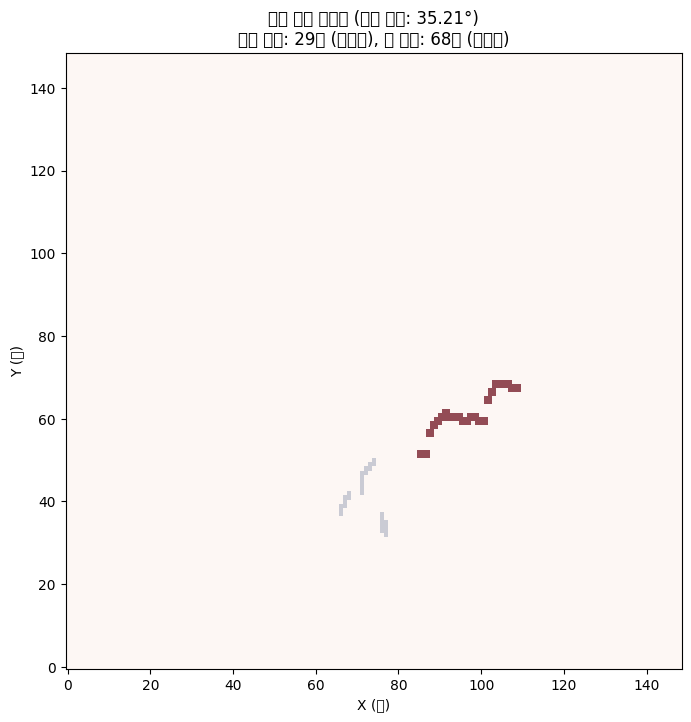

In [ ]:
start_pixel_below, start_pixel_above = find_start_pixels_with_lat_logic(f,lu_index_value=13, split_lat=35.21)

In [ ]:
def expand_lu_index_from_start_pixels(wrf_file_path, start_pixels_below, start_pixels_above, lu_index_value=13):
    """
    주어진 시작 픽셀 집합을 기반으로 면적을 확장합니다.
    """
    try:
        ds = xr.open_dataset(wrf_file_path)
    except FileNotFoundError:
        print(f"오류: 파일을 찾을 수 없습니다: {wrf_file_path}")
        return None

    lu_index_da = ds['LU_INDEX'].isel(Time=0)
    landmask_da = ds['LANDMASK'].isel(Time=0)

    original_lu_index_values = lu_index_da.values.copy()
    rows, cols = original_lu_index_values.shape

    # 원본 및 목표 면적 계산
    original_area = np.sum(original_lu_index_values == lu_index_value)
    target_area = original_area * 2

    print(f"original: {original_area} pixel")
    print(f"target: {target_area} pixel")

    # 확장 시작
    new_lu_index_values = original_lu_index_values.copy()
    current_area = original_area

    current_expansion_below = start_pixels_below.copy()
    current_expansion_above = start_pixels_above.copy()

    while current_area < target_area:
        new_pixels_to_add_below = set()
        new_pixels_to_add_above = set()

        # '아래' 그룹 확장: (y, x-1) 방향
        for y, x in current_expansion_below:
            next_y, next_x = y, x - 1
            if 0 <= next_y < rows and 0 <= next_x < cols and landmask_da.values[next_y, next_x] == 1:
                if new_lu_index_values[next_y, next_x] != lu_index_value:
                    new_pixels_to_add_below.add((next_y, next_x))
            next_y, next_x = y, x - 2
            if 0 <= next_y < rows and 0 <= next_x < cols and landmask_da.values[next_y, next_x] == 1:
                if new_lu_index_values[next_y, next_x] != lu_index_value:
                    new_pixels_to_add_below.add((next_y, next_x))
            next_y, next_x = y - 1, x
            if 0 <= next_y < rows and 0 <= next_x < cols and landmask_da.values[next_y, next_x] == 1:
                if new_lu_index_values[next_y, next_x] != lu_index_value:
                    new_pixels_to_add_below.add((next_y, next_x))
            next_y, next_x = y - 1, x - 1
            if 0 <= next_y < rows and 0 <= next_x < cols and landmask_da.values[next_y, next_x] == 1:
                if new_lu_index_values[next_y, next_x] != lu_index_value:
                    new_pixels_to_add_below.add((next_y, next_x))
            next_y, next_x = y - 1, x - 2
            if 0 <= next_y < rows and 0 <= next_x < cols and landmask_da.values[next_y, next_x] == 1:
                if new_lu_index_values[next_y, next_x] != lu_index_value:
                    new_pixels_to_add_below.add((next_y, next_x))

        for y, x in current_expansion_below:
            next_y, next_x = y, x - 1
            if 0 <= next_y < rows and 0 <= next_x < cols and landmask_da.values[next_y, next_x] == 1:
                if new_lu_index_values[next_y, next_x] != lu_index_value:
                    new_pixels_to_add_below.add((next_y, next_x))
            next_y, next_x = y - 1, x - 1
            if 0 <= next_y < rows and 0 <= next_x < cols and landmask_da.values[next_y, next_x] == 1:
                if new_lu_index_values[next_y, next_x] != lu_index_value:
                    new_pixels_to_add_below.add((next_y, next_x))

        # '위' 그룹 확장: (y+1, x+1) 방향
        for y, x in current_expansion_above:
            next_y, next_x = y + 2, x + 1
            if 0 <= next_y < rows and 0 <= next_x < cols and landmask_da.values[next_y, next_x] == 1:
                if new_lu_index_values[next_y, next_x] != lu_index_value:
                    new_pixels_to_add_above.add((next_y, next_x))
            next_y, next_x = y + 1, x + 1
            if 0 <= next_y < rows and 0 <= next_x < cols and landmask_da.values[next_y, next_x] == 1:
                if new_lu_index_values[next_y, next_x] != lu_index_value:
                    new_pixels_to_add_above.add((next_y, next_x))
            next_y, next_x = y - 1, x + 1
            if 0 <= next_y < rows and 0 <= next_x < cols and landmask_da.values[next_y, next_x] == 1:
                if new_lu_index_values[next_y, next_x] != lu_index_value:
                    new_pixels_to_add_above.add((next_y, next_x))

        if not new_pixels_to_add_below and not new_pixels_to_add_above:
            print("더 이상 확장할 유효한 육지 픽셀이 없어 확장을 중단합니다.")
            break

        all_new_pixels = new_pixels_to_add_below.union(new_pixels_to_add_above)
        for y, x in all_new_pixels:
            if current_area < target_area:
                new_lu_index_values[y, x] = lu_index_value
                current_area += 1
            else:
                break

        current_expansion_below = new_pixels_to_add_below
        current_expansion_above = new_pixels_to_add_above

    # 결과 시각화
    final_area = np.sum(new_lu_index_values == lu_index_value)
    print(f"최종 면적: {final_area} 픽셀")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_lu_index_values == lu_index_value, cmap='terrain', origin='lower')
    axes[0].set_title(f'original \n(pixel: {original_area})')
    axes[1].imshow(new_lu_index_values == lu_index_value, cmap='terrain', origin='lower')
    axes[1].set_title(f'modified\n(pixel: {final_area})')
    plt.tight_layout()
    plt.show()

    modified_lu_index_da = xr.DataArray(
        new_lu_index_values,
        dims=lu_index_da.dims,
        coords=lu_index_da.coords,
        attrs=lu_index_da.attrs
    )
    return modified_lu_index_da

original: 572 pixel
target: 1144 pixel
최종 면적: 1144 픽셀


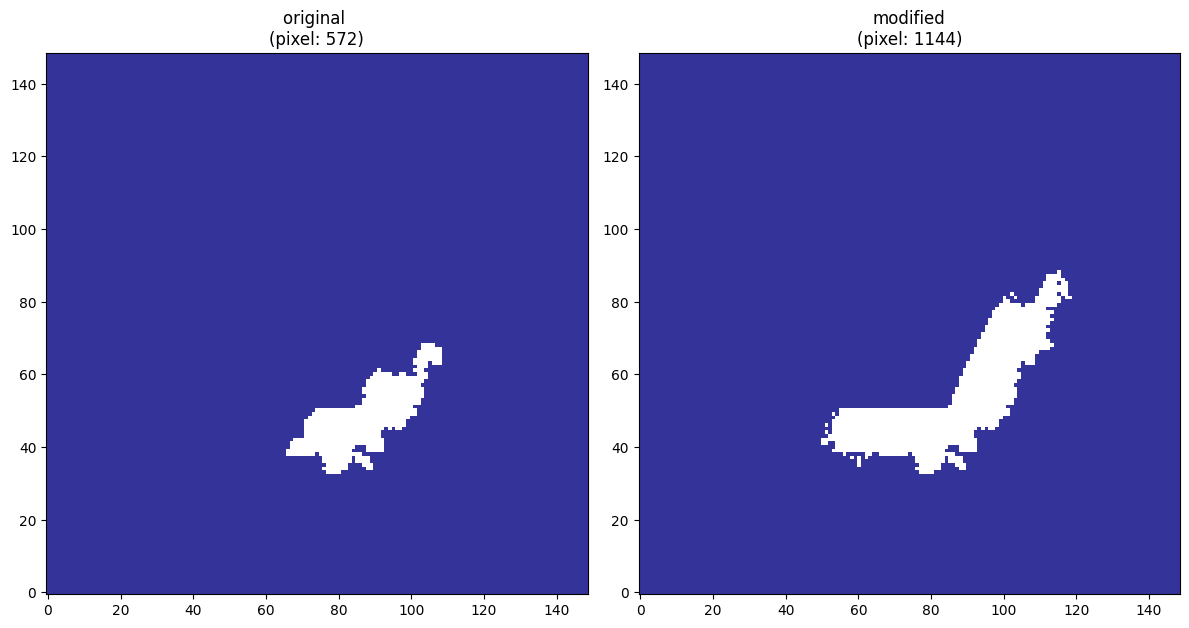


LU_INDEX 데이터가 위도 기준에 따라 성공적으로 확장되었습니다.


In [ ]:
# --- 메인 스크립트 실행 ---
if __name__ == "__main__":

    if start_pixel_below is not None or start_pixel_above is not None:
        # 2. 찾은 시작 픽셀을 기반으로 확장
        expanded_data = expand_lu_index_from_start_pixels(
            f,
            start_pixel_below,
            start_pixel_above,
            lu_index_value=13
        )
        if expanded_data is not None:
            print("\nLU_INDEX 데이터가 위도 기준에 따라 성공적으로 확장되었습니다.")

In [ ]:
# 다시 netCDF 파일로 저장
df_new = df
#print(df_new)

# 시간 차원 추가
expanded_with_time = expanded_data.expand_dims(Time=df.Time)
df_new['LU_INDEX'] = expanded_with_time

f_new = '/content/drive/MyDrive/UHI/geo_em.01.nc'

#print(type(df_new))
df_new.to_netcdf(f_new)

/tmp/ipython-input-2676895252.py:12: UserWarning: Unlimited dimension(s) {'time'} declared in 'dataset.encoding', but not part of current dataset dimensions. Consider removing {'time'} from 'dataset.encoding'.
  df_new.to_netcdf(f_new)


<xarray.DataArray 'LU_INDEX' (Time: 1, south_north: 149, west_east: 149)> Size: 89kB
[22201 values with dtype=float32]
Coordinates:
  * Time     (Time) int64 8B 0
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    units:        category
    description:  Dominant category
    stagger:      M
    sr_x:         1
    sr_y:         1


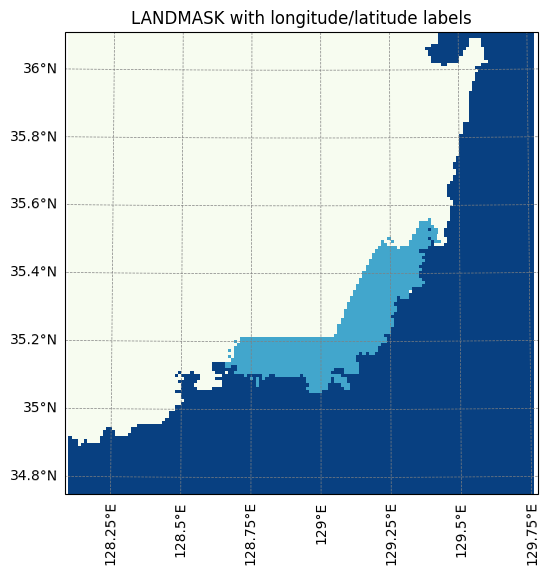

In [ ]:
f = '/content/drive/MyDrive/UHI/geo_em.01.nc'
df = xr.open_dataset(f)
print(df["LU_INDEX"])

lat = df["CLAT"].isel(Time=0)
lon = df["CLONG"].isel(Time=0)
lu = df["LU_INDEX"].isel(Time=0)

lambert = ccrs.LambertConformal(
    central_longitude=128.93,
    central_latitude=35.43,
    standard_parallels=(30.0, 60.0)
)

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=lambert)

mesh = ax.pcolormesh(
    lon, lat, lu,
    transform=ccrs.PlateCarree(),
    cmap="GnBu", shading="nearest"
)

#ax.coastlines(resolution="10m", linewidth=0.8)
#ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
#plt.colorbar(mesh, ax=ax, label=str(var.name))

# 영역 맞춤
ax.set_extent([float(lon.min()), float(lon.max()),
               float(lat.min()), float(lat.max())],
              crs=ccrs.PlateCarree())

# --- 경위도 라벨 표시 ---
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linestyle="--", linewidth=0.5, color="gray"
)

# 원하는 방향만 표시
gl.top_labels    = False   # 위쪽 라벨
gl.bottom_labels = True    # 아래쪽 라벨
gl.left_labels   = True    # 왼쪽 라벨
gl.right_labels  = False   # 오른쪽 라벨

# 라벨을 지도 안에서 바깥으로 빼기
gl.x_inline = False
gl.y_inline = False

gl.xlabel_style = {"size": 10, "color": "black"}
gl.ylabel_style = {"size": 10, "color": "black"}

plt.title("LANDMASK with longitude/latitude labels")
plt.show()